# 1D Burgers' equation, finite volume

_Gilbert François Duivesteijn_

In [9]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.integrate import odeint
from scipy.linalg import toeplitz

from IPython import display

Burgers' equation or Bateman–Burgers equation is a fundamental partial differential equation occurring in various areas of applied mathematics, such as fluid mechanics, nonlinear acoustics, gas dynamics, and traffic flow. The equation was first introduced by Harry Bateman in 1915 and later studied by Johannes Martinus Burgers in 1948 [1].

For a given field $u(x,t)$ and diffusion coefficient (or kinematic viscosity, as in the original fluid mechanical context) $\nu$ , the general form of Burgers' equation (also known as viscous Burgers' equation) in one space dimension is the dissipative system:

\begin{align}
\frac{\partial u}{\partial t} + \frac{\partial f(u)}{\partial x} &= \nu\frac{\partial^2 u}{\partial x^2} .\\
\end{align}

When the diffusion term is absent (i.e. $\nu=0$), Burgers' equation becomes the inviscid Burgers' equation:

\begin{align}
\frac{\partial u}{\partial t} + \frac{\partial f(u)}{\partial x} &= 0 .\\
\end{align}

With $f(u) = \frac{u^2}{2}$ and applying the chain rule, we can write this non-linear equation, known as the Burgers' equation as

\begin{align}
\frac{\partial u}{\partial t} + \frac{\partial f(u)}{\partial u} \frac{\partial u}{\partial x} &= 0 \\
\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} &= 0. \\
\end{align}

where $\frac{\partial f(u)}{\partial u}$ can be seen as the local wave speed.


Writing the Burgers' equation in integral form
\begin{align}
\int_{a}^{b} \left( \frac{\partial u}{\partial t} + \frac{\partial f(u)}{\partial x} \right)dx &= 0 \\
\frac{d}{dt} \int_{a}^{b} udx + \left. f(u) \right|_a^b &= 0
\end{align}

Bringing the $f(u)$ term to the other side
\begin{align}\label{eq:burgers_int}
\frac{d}{dt} \int_{a}^{b} udx &= f(u(a)) - f(u(b))
\end{align}

Now, $f(u(b)) - f(u(a))$ can be seen as the flux. 

For example if $u$ is denoted as the density, then the integral of $u$ over the spacial domain $\int_{a}^{b} udx$ means the total amount of mass inside this range and $\frac{d}{dt}$ is the rate of change.

In words the integral form of the Burgers' equation (\ref{eq:burgers_int}) can be described as:

>The rate of change of mass inside a volume is equal to the rate of flux going into the volume minus the rate of flux going out of the volume.

Substituting $f(u) = \frac{u^2}{2}$ into (\ref{eq:burgers_int}) gives

\begin{align}\label{eq:burgers_int2}
\frac{d}{dt} \int_{a}^{b} udx + \frac{u(b)^2}{2} - \frac{u(a)^2}{2} &= 0
\end{align}

[1] [Burgers' equation](https://en.wikipedia.org/wiki/Burgers%27_equation)

## Central flux scheme

```
  +------+------+------+------+------+--/ /-+------+------+------+------+
  |  U0  |  U1  |      |      |      |  \ \ |      |      |      |  Un  |
  |      |      |      |      |      |  / / |      |      |      |      |
  +------+------+------+------+------+--\ \-+------+------+------+------+
  :  i=0 :  i=1                                            i=n-1    i=n
  :      :
  :      :
i-1/2  i+1/2    
```

For the 1D case, when denoting the cells as $i$ from $0$ to $n$, the cell boundaries on the left and right hand side are denoted as $i-\frac{1}{2}$ and $i+\frac{1}{2}$. The state $u_i$ is the average of $\bar{u}$ inside a volume, defined by

\begin{align}
\bar{u_i} &= \frac{1}{\Delta x}\int_{i-\frac{1}{2}}^{i_\frac{1}{2}} u dx \\
\end{align}


Now we can write e.g. the flux of the left and right boundary of cell $i$ as
\begin{align}
f_{i-\frac{1}{2}} = \frac{f_i + f_{i-1}}{2} \\
f_{i+\frac{1}{2}} = \frac{f_i + f_{i+1}}{2}
\end{align}
where $f_i = f(\bar{u_i})$ and $\bar{u_i}$ = the average value of u in cell $i$.

The equation to solve is

\begin{align}
\frac{\partial \bar{u_i}}{\partial t} = \frac{f_{i-\frac{1}{2}}  - f_{i+\frac{1}{2}}}{\Delta x}
\end{align}

This solution is _exact_ if $f_{i+\frac{1}{2}} = u(x_{i+\frac{1}{2}})$ and $f_{i-\frac{1}{2}} = u(x_{i-\frac{1}{2}})$. The reason why finite volume method is an approximation is that we don't have the state values at the interfaces, but the average values inside the volumes.



_Note that with the central schema, the solution is **unstable**, when a shock wave appears. For a stable solution with shock waves, another schema is needed._

In [3]:
# number of cells in 1D space
n = 100
u = np.zeros(shape=(n,))

# space
x0 = 0
xn = 1
dx = (xn - x0)/n
x_interface = np.linspace(x0, xn, n+1)
x = x_interface[0:n] + dx/2

# time
t0 = 0
tn = 0.5
t_steps = 200
t = np.linspace(t0, tn, t_steps)


# Initial condition
u_init = np.sin(2*np.pi*x)

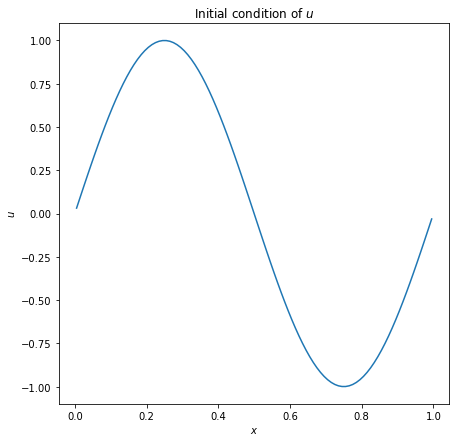

In [4]:
plt.figure(figsize=(7,7))
plt.plot(x, u_init, label="$\bar{u}$")
plt.xlabel("$x$")
plt.ylabel("$u$")
plt.title("Initial condition of $u$")
plt.show()

In [5]:
def dudt_central(u, t, dx):
    # u denotes state in cell centers
    # f denotes f(u) in cell centers, using Burgers' equation f(u) = u^2/2
    f = u**2 / 2
    
    # Flux at inner domain: from f_{0+1/2} to f_{n-1/2}
    f_interface = (f[0:n-1] + f[1:n]) / 2
    
    # Add flux at boundaries of the domain at interfaces f_{0-1/2} and f_{n+1/2}
    f_interface = np.hstack([0, f_interface, 0])
    
    # If we have n cells, we have n+1 cell boundaries.
    assert len(f_interface) == len(u) + 1 
    
    # Compute the time derivative as the difference of flux directed into the cell.
    du_dt = (f_interface[0:n] - f_interface[1:n+1])/dx
    return du_dt


In [6]:
u = odeint(dudt_central, u_init, t, args=(dx,))

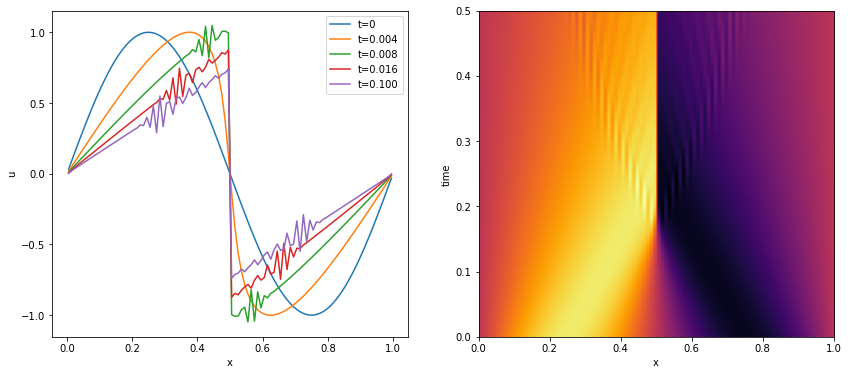

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
#axs[0].set_ylim(min(U0, Un),max(U0,Un))
axs[0].plot(x, u[0], label="t=0")
#axs[0].plot(x, u[25], label="t=0.002")
axs[0].plot(x, u[50], label="t=0.004")
axs[0].plot(x, u[100], label="t=0.008")
axs[0].plot(x, u[150], label="t=0.016")
axs[0].plot(x, u[199], label="t=0.100")
axs[0].legend()
axs[0].set_ylabel("u")
axs[0].set_xlabel("x")
axs[1].imshow(u, aspect="auto", cmap="inferno", origin="lower", extent=[0, 1, t0, tn])
axs[1].set_xlabel(f"x")
axs[1].set_ylabel("time")
plt.show()

In [8]:
# Animation of the solution over the integrated time span.

def animate(frame):
    y = u[frame]
    line.set_data((x, y))
    plt.title(f"t={tn * frame / t_steps:0.2f}")

    
fig = plt.figure(figsize=(12,6))
lines = plt.plot([])
line = lines[0]
plt.xlim([x0, xn])
plt.ylim([-1.1, 1.1])
plt.xlabel("x")
plt.ylabel("u")
plt.title("")
  
anim = FuncAnimation(fig, animate, frames=t_steps, interval=50)
video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()